<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/shuby-dev/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [1]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.models as models
import pandas as pd

%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import string
from google.colab import drive
drive.mount('/content/drive')
# print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/drive
cpu


## Loading Data

In [2]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)

## Preprocessing

### Preprocessing Helper Functions

Create the pipeline for handling data

In [3]:
def nomalize_img(img):
  cliped_img = np.clip(img, 0, 255)
  subtracted_img = cliped_img - cliped_img.mean() + 10
  normalized_img = subtracted_img / np.max(subtracted_img) * 255
  return normalized_img

In [4]:
def extract_key_item(original, padding=2, threshold=100 , show_all = False, debug=False):
  stages = None
  img = cv2.normalize(original, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  img_blur = cv2.GaussianBlur(img, (7, 7), 0)
  (_, thresh) = cv2.threshold(img_blur, 65, 255, cv2.THRESH_BINARY)
  if debug: plt.imshow(img_blur); plt.show()
  if debug: plt.imshow(thresh); plt.show()
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  key_items = []
  bounding_box_cords = []
  for c in contours:
      x,y,w,h = cv2.boundingRect(c)
      if show_all or debug: cv2.rectangle(img, (x, y), (x + w, y + h), 255, 1)
      if(w < 10 and h < 10): # select elements with at least 10px width or 10 px height
        continue
      dup = False
      for (px, py) in bounding_box_cords:
        if abs(px-x)+abs(py-y) < 10:
          dup = True
      if dup: continue   
      key_items.append(original[y-padding:y+h+padding,x-padding:x+w+padding].copy())
      
      bounding_box_cords.append((x,y,))
  if show_all: 
    stages = [img_blur, thresh, img]
  if debug: plt.imshow(img); plt.show()
  return stages, key_items

In [5]:
def pad_to_fixed_size(img, width, height):
  row, col = img.shape
  if row > height or col > width: 
    return None
  pl = (width - col)// 2
  pt = (height - row)// 2
  pr = (width - col - pl)
  pb = (height - row - pt)
  return np.pad(img, [(pt,pb),(pl,pr)], 'constant')

In [6]:
def merge_key_items(key_items):
  if len(key_items) >= 2:
    item1 = pad_to_fixed_size(key_items[0],28,56)
    item2 = pad_to_fixed_size(key_items[1],28,56)
    if item1 is None or item2 is None: return None
    result = np.concatenate((item1,item2), axis = 1)
    return result 
  return None

In [7]:
def pre_processing(original, show_all=False, debug=False):
  normalized_img = nomalize_img(original.copy())
  if debug: plt.imshow(normalized_img); plt.show()
  extract_stages, key_items = extract_key_item(normalized_img, show_all=show_all, debug=debug)
  if debug: [(plt.imshow(item), plt.show()) for item in key_items]
  result = merge_key_items(key_items)
  #result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  #result = cv2.fastNlMeansDenoising(result, None, 3, 7)
  #result = cv2.threshold(result, 65, 255, cv2.THRESH_BINARY)
  #result = np.asarray(result)
  if result is None: return normalized_img, None, False
  stages = None
  if show_all:
    stages = [original, normalized_img, *extract_stages, *key_items, result]
  return result, stages, True

In [8]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1 = np.argmax(label[0:10])
    l2 = mapping[np.argmax(label[10:])]
    readables.append((l1,l2,))
  return readables

In [9]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])
        #plt.colorbar()
    plt.show()

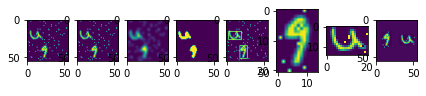

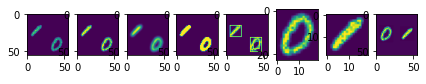

In [10]:
# Test the preprocessing functions
for ind in np.random.choice(training_data.shape[0], 3, replace=False):
  img = training_data[ind]
  _, stages,_ = pre_processing(img, show_all=True)
  if stages is not None: img_grid(1,len(stages),stages)

In [11]:
# transform all data to the output format
def process_data(data):
  output, bad_index = [], []
  for i in range(len(data)):
      result,_,valid = pre_processing(data[i])
      output.append(result)
      if not valid:
        bad_index.append(i)
  output = np.array(output).astype('float64')
  return output, bad_index

def normalize_data(data):
  output = []
  for i in range(len(data)):
      output.append(nomalize_img(data[i].copy()))
  output = np.array(output).astype('float64')
  return output

### Processing The Data

In [12]:
normalized_training_data = normalize_data(training_data)
processed_training_data, bad_training_index = process_data(training_data)

print(f'Number of training data element unable to be separated: {len(bad_training_index)}')
processed_training_data = np.delete(processed_training_data, bad_training_index, axis=0)
processed_training_labels = np.delete(training_labels, bad_training_index, axis=0)

print("Normalized data set")
print(normalized_training_data.shape)
print(training_labels.shape)
print("Processed (separated) data set")
print(processed_training_data.shape)
print(processed_training_labels.shape)

Number of training data element unable to be separated: 4277
Normalized data set
(30000, 56, 56)
(30000, 36)
Processed (separated) data set
(25723, 56, 56)
(25723, 36)


In [13]:
normalized_testing_data = normalize_data(testing_data)
processed_testing_data, bad_testing_index = process_data(testing_data)
print("Normalized testing data set")
print(normalized_testing_data.shape)
print("Processed (separated) testing data set")
print(f'Number of test data element unable to be processed: {len(bad_testing_index)}')
print(processed_testing_data.shape)

Normalized testing data set
(15000, 56, 56)
Processed (separated) testing data set
Number of test data element unable to be processed: 2066
(15000, 56, 56)


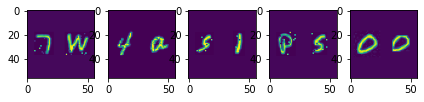

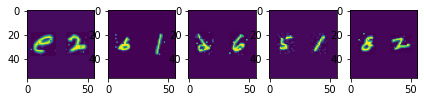

[(7, 'w'), (4, 'a'), (1, 's'), (5, 'p'), (0, 'v'), (2, 'e'), (1, 'b'), (6, 'd'), (5, 'i'), (8, 'z')]


In [14]:
def show_random_sample(n):
  index = np.random.choice(processed_training_data.shape[0], n, replace=False)  
  img_grid(n//5,5,processed_training_data[index])
  print(convert_labels_to_readables(processed_training_labels[index]))
show_random_sample(10)

Put the data into dataloader

In [15]:
def make_training_data_loader(data, label, batch_size=30, shuffle=True, num_workers=2):
  data_tensor = torch.from_numpy(data[:,None]).float()
  number_label_tensor =  torch.from_numpy(np.argmax(label[:,0:10],1))
  letter_label_tensor = torch.from_numpy(np.argmax(label[:,10:36],1))
  multi_label_tensor = torch.stack((number_label_tensor,letter_label_tensor), axis=1)
  multi_label_tensor = multi_label_tensor
  combined_dataset = TensorDataset(data_tensor, multi_label_tensor)
  train_size = int(0.9*len(combined_dataset))
  validation_size = len(combined_dataset)-train_size
  training_dataset, validation_dataset = random_split(combined_dataset, [train_size, validation_size])
  training_dataloader = DataLoader(training_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  combined_dataloader = DataLoader(combined_dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  return training_dataloader, validation_dataloader, combined_dataloader

norm_training_loader, norm_validation_loader, _ = make_training_data_loader(normalized_training_data, training_labels)
processed_training_loader, processed_validation_loader, _ = make_training_data_loader(processed_training_data, processed_training_labels)

## Training Model

### Multi-Output Model

Initalize the Multilabel Model

In [16]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
         # 4 convolution layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        
        self.pool2 = nn.MaxPool2d(2, 2)

        # 3 Dense Layer
        self.fc11 = nn.Linear(256*3*3, 1000)
        self.fc12 = nn.Linear(256*3*3, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(100, 10)
        self.fc32 = nn.Linear(1000, 26)

    def forward(self, x):
        # Convolution Layers
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        # print(x.size())
        # Dense Layers
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        l1 = F.relu(self.fc21(F.relu(self.fc11(x))))
        l2 = F.relu(self.fc22(F.relu(self.fc12(x))))
        l1 = self.fc31(l1)
        l2 = self.fc32(l2)
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Custom Res Net with Multi Output

In [96]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class CustomResNet(nn.Module):

    def __init__(self, norm_layer = None, groups = 1, width_per_group = 64):
        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        super(CustomResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.layer1 = self._make_layer(models.resnet.BasicBlock, 64, 2)
        self.layer2 = self._make_layer(models.resnet.BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(models.resnet.BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(models.resnet.BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc1 = nn.Linear(2048, 10)
        self.fc2 = nn.Linear(2048, 26)
      
    def _make_layer(self, block, planes, blocks, stride = 1, dilate = False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes, planes,groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        l1 = self.fc1(x)
        l2 = self.fc2(x)
        return l1,l2


### Training and Validation

Initialize network validation and training function

In [93]:
def validate_model(model, validation_dataloader):
  digit_acc, letter_acc = 0, 0
  print("Starting Validation Iteration")
  for i, validation_data in enumerate(tqdm(validation_dataloader)):
    inputs, labels = validation_data
    o1, o2 = model(inputs)
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float())
  digit_acc = digit_acc/len(validation_dataloader)
  letter_acc = letter_acc / len(validation_dataloader)
  print(f'\n Digit Accuracy: {digit_acc.item()}, Letter Accuracy: {letter_acc.item()}')
  return (digit_acc.item(), letter_acc.item())

In [94]:
def train_network(net, dataloader, validation_dataloader, lr = 0.005, momentum = 0.9, max_epoch = 10, criterion = nn.CrossEntropyLoss()):
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=1e-5)
  running_loss = 0.0
  digits_accs, letter_accs = [], []
  for epoch in range(max_epoch):  # loop over the dataset multiple times
      cnt = 0
      print("Starting Training Iteration")
      for i, data in enumerate(tqdm(dataloader)):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          cnt+=1
      print('[%d] loss: %.3f' % (epoch + 1, running_loss / cnt))
      running_loss, cnt = 0.0, 0
      if validation_dataloader is not None:
        digit_acc, letter_acc = validate_model(net, validation_dataloader)
        digits_accs.append(digit_acc)
        letter_accs.append(letter_acc)
  return (digits_accs, letter_accs)

In [81]:
def lr_test_bench():
  for lr in [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]:
    multi_net = MultiNet()
    multi_net_criterion = nn.CrossEntropyLoss()
    lr, epoch = 0.001, 1 
    def ml_criterion(output, labels):
      o1, o2 = output
      l1, l2 = labels[:,0], labels[:,1]
      loss1 = multi_net_criterion(o1,l1)
      loss2 = multi_net_criterion(o2,l2)
      return loss1 + loss2
    res = train_network(multi_net, norm_training_loader, norm_validation_loader, criterion=ml_criterion, lr=lr, max_epoch=1)
# lr_test_bench()

In [ ]:
def train_model(net = MultiNet(), run_validation = True, lr = 0.001, epoch = 1):
  multi_net_criterion = nn.CrossEntropyLoss()
  def ml_criterion(output, labels):
    o1, o2 = output
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2
  if run_validation:
    res = train_network(net, norm_training_loader, norm_validation_loader, criterion=ml_criterion, lr=lr, max_epoch=epoch)
    digit_accuracies, letter_accuracies = res
  else: 
    res = train_network(net, norm_training_loader, None, criterion=ml_criterion, lr=lr, max_epoch=epoch)
  return net
multi_net = train_model(net=CustomResNet(), lr=0.001, epoch=7)

Starting Training Iteration


  2%|▏         | 17/900 [00:42<36:06,  2.45s/it]

## Results

Quick Sanity check

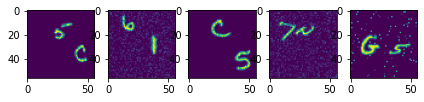

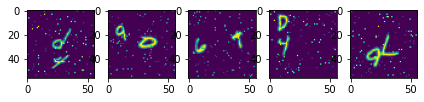

[(5, 'c'), (6, 'i'), (5, 'c'), (7, 'n'), (5, 'g'), (4, 'd'), (9, 'o'), (6, 't'), (0, 'y'), (9, 'l')]


In [87]:
img_grid(2, 5, normalized_testing_data[10000:100010])
l1, l2 = multi_net(torch.from_numpy(normalized_testing_data[10000:10010, None]).float())
l1 = np.argmax(l1.detach().numpy(), axis=1)
l2 = np.argmax(l2.detach().numpy(), axis=1)
print(list(zip(l1,map(lambda x: mapping[x], l2))))

In [88]:
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s

category = []
k = 0
while(k<15000):
  l1,l2 = multi_net(torch.from_numpy(normalized_testing_data[k:k+100, None]).float())
  l1 = np.argmax(l1.detach().numpy(), axis=1)
  l2 = np.argmax(l2.detach().numpy(), axis=1)
  for i in range(0, len(l1)):
    a = LabelToString(l1[i], True)
    b = LabelToString(l2[i], False)
    category.append(a+b)
    k += 1

In [90]:
id = []
for i in range(0, 15000):
  id.append(i)
# need to create data dict
data = {
    '# Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['# Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results.csv', index = False, header=True)

        # Id                              Category
0          0  100000000000000000000000000001000000
1          1  000010000000000000000000000000000010
2          2  000000000100000000000000000010000000
3          3  100000000000000000000100000000000000
4          4  000000100000000000010000000000000000
...      ...                                   ...
14995  14995  000100000000001000000000000000000000
14996  14996  000100000000000000000000001000000000
14997  14997  000000100000000000000000001000000000
14998  14998  010000000000000000100000000000000000
14999  14999  001000000000000000001000000000000000

[15000 rows x 2 columns]
